# Sentinel 5P Atmospheric Gas Map Tool

## Overview
This Jupyter notebook will alow you to view the atmospheric gas data from Sentinel 5P on a map of Iberia, along with the Canary and Baleric islands. The gas options are as follows:
- Methane (CH4)
- Nitrogen dioxide (NO2)
- Carbon monoxide (CO)
- Formaldehyde (HCHO)
- Ozone (O3)
- Sulfur dioxide (SO2)

Please run the code in order and follow any instructions given. Should you have any problems, please refer to the relevant section in the user manual. 

<u>WARNING - If you wish to run this tool twice (for different dates) then the kernel will need to be reset each time.</u> 

Run the section below imports the packages needed to run the script.

In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import openeo
from shapely.geometry import shape, Point
from rasterio import warp
from matplotlib import cm
from matplotlib.colors import Normalize
import folium.raster_layers
import rasterio
from rasterio import warp
import numpy as np

## Connect to OpenEO

The code below establishes a connection with the Copernicus openEO platform which provides a wide variety of earth observation datasets

- If this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 

- If you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 

- If there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## View list of landfills. 

For easy reference the complete list of landfills can be viewed by running the following piece of code.

In [3]:
landfills = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")

landfills

,Landfill,Lat,Long,geometry
0,ALBACETE,38.994590,-1.776850,POINT (-1.77685 38.99459)
1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,37.390644,-2.173969,POINT (-2.17397 37.39064)
2,ALCAL� DEL R�O (LA VEGA-SEVILLA),37.599190,-5.999450,POINT (-5.99945 37.59919)
3,ALC�ZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,39.432932,-3.225099,POINT (-3.22510 39.43293)
4,ALMER�A: CMA,36.878879,-2.286746,POINT (-2.28675 36.87888)
5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,41.530854,1.806387,POINT (1.80639 41.53085)
6,CA�ADA HERMOSA: MURCIA,37.980683,-1.288079,POINT (-1.28808 37.98068)
7,DAIMIEL,39.064526,-3.584598,POINT (-3.58460 39.06453)
8,ECOPARQUE DE TOLEDO: GESMAT,39.861188,-4.163804,POINT (-4.16380 39.86119)
9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),28.058762,-15.423571,POINT (-15.42357 28.05876)


## Choosing date and gas type

This downloads the gas concentration data for a particular date. The two parameters you need to modify before running the code are:

- temporal_extent = ["2023-01-31", "2023-03-12"] (change this to your chosen date range using "YYYY-MM-DD" format)
- bands=["CH4"], (change this to either one of 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4')

Please note that the temporal extent dates <u>MUST BE IDENTICAL</u> because we are only choosing a single date.

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.

In [4]:
cube = connection.load_collection(
    collection_id="SENTINEL_5P_L2", 
    temporal_extent=["2023-01-23", "2023-01-23"], # Select a date range using the format YYYY-MM-DD
    spatial_extent={"west": -19.5, "south": 20.0, "east": 9.0, "north": 44.5}, # these coordinates define the area to be downloaded (Peninsular Spain, the Canaries and Baleric islands along with some of North Africa)
    bands=["CH4"], # The options for gas monitoring are: 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4'
)
cube.download("Sentinel-5P_Spain.GTiff")


## Fitting the data to the map

Currently the data is projected in EPSG:4326 and to display correctly on the map it needs to be EPSG:3857. Running the script does that. You do not need to change anything here. 

NOTE - If you recieve the error "CPLE_AppDefinedError: Deleting Sentinel-5P_Spain3857.GTiff failed: Permission denied" this is because the tool has already been run once and needs to have its kernel reset.


In [5]:
# The destination coordinate reference system (CRS)
dst_crs = 'EPSG:3857'

# Open the gas data file that is in ESPG:4326 and calculate its bounds
with rasterio.open('Sentinel-5P_Spain.GTiff') as src:
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    # Copy and update the metadata from the source dataset
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Create a new gas data file in EPSG:3857 
    with rasterio.open('Sentinel-5P_Spain3857.GTiff', 'w', **kwargs) as dst: #if you wish to run this without restarting the kernel, you will need to rename this
        # Loop through each band in the source dataset
        for ind in range(1, src.count + 1):
            # Reproject each band and write it to the destination dataset
            rasterio.warp.reproject(
                source=rasterio.band(src, ind),
                destination=rasterio.band(dst, ind),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.nearest)

## Viewing the data. 

This section of code can be run to produce the map. The landfills are also shown for reference and when clicked will display their name. 

The warning "...Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect..." can be ignored. 

C:\Users\kinse\AppData\Local\Temp\ipykernel_4204\2556639412.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = PZ_landfill_Locations.geometry.centroid



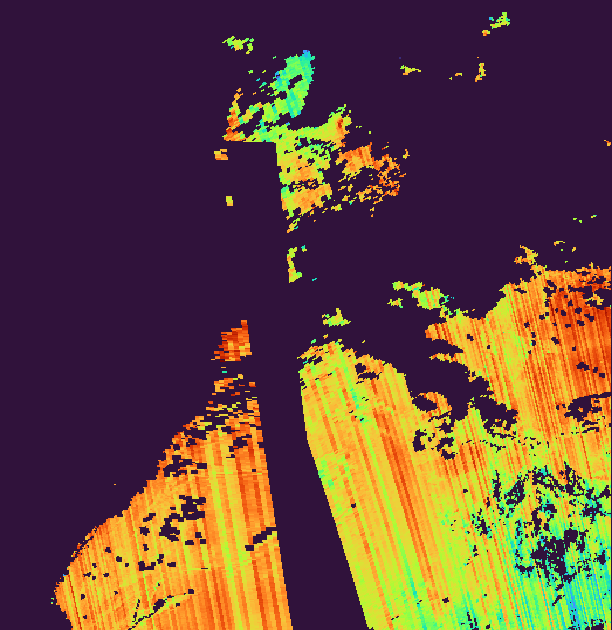

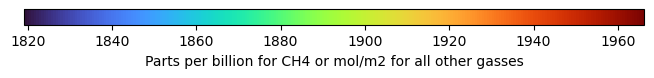

In [6]:
# This section loads the map 

#This is the reprojected gas data
gas_data = r'C:\GIS_Course\EGM722\Project\Sentinel-5P_Spain3857.GTiff'

# Open raster file, load values and prepare them to be displayed.
dataset = rasterio.open(gas_data, 'r')  
rasdata = dataset.read()[0]  
rasdata_normed = rasdata / rasdata.max() * 10  
                                 
# When the data is displayed, this says to ignore values of zero. 
non_zero_values = rasdata[rasdata != 0]
min_value = non_zero_values.min()
max_value = non_zero_values.max()
normalized_data = (non_zero_values - min_value) / (max_value - min_value)

# Create a colourmap for the non-zero values
colourmap = cm.turbo 
colourmap_index = np.zeros_like(rasdata, dtype=np.float64)
colourmap_index[rasdata != 0] = normalized_data

#Loading in the landfill locations
PZ_landfill_Locations = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")

# This creates the map and centres it on the geometries.
centroids = PZ_landfill_Locations.geometry.centroid
center = [centroids.y.mean(), centroids.x.mean()]
gas_concentration_map = folium.Map(location=center, zoom_start=5, tiles='CartoDB Positron')

# Adding the PreZero landfill locations to the map and making them clickable for info
for feature in PZ_landfill_Locations.iterfeatures():
    # Extract feature number from properties
    feature_number = feature['properties']['Landfill'] 
    # Extract coordinates of the feature
    coordinates = feature['geometry']['coordinates']
    # Create a marker with label for each feature
    folium.Marker(location=[coordinates[1], coordinates[0]], 
                  popup=f"Feature {feature_number}").add_to(gas_concentration_map)

# Adding the gas concentration dataset to the map
folium.raster_layers.ImageOverlay(
    image=colourmap(colourmap_index),
    name='gas concentration in atmosphere',
    opacity=0.6,
    bounds=[[20.0, -19.5], [44.4, 9.0]],  # this should be the same as the spatial extent of cube 
    interactive=False,
    cross_origin=False,
    zindex=1
).add_to(gas_concentration_map)

# Creating the legend for gas concentration
fig, ax = plt.subplots(figsize=(8, 0.2))
cbar = plt.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min_value, vmax=max_value),
                                      cmap=colourmap),
                    cax=ax, orientation='horizontal')
cbar.set_label('Parts per billion for CH4 or mol/m2 for all other gasses')

# Display the map
gas_concentration_map

## Interpreting this map

- CH4 measurements are column averaged dry air mixing ratio of methane (parts per billion). Ranges of 1,600 - 2,000
- NO2 measurements are Nitrogen dioxide tropospheric column (mol/m2). Ranges of 0 - 0.0003
- CO measurements are Carbon monoxide total column (mol/m2). Ranges of 0 - 0.1
- HCHO measurements are Formaldehyde troposheric vertical column (mol/m2). Ranges of 0 - 0.001
- O3 measurements are Ozone total column (mol/m2). Ranges of 0 - 0.36
- SO2 measurements are Sulfur dioxide total column (mol/m2). Ranges of 0 - 0.01

More information: https://docs.sentinel-hub.com/api/latest/data/sentinel-5p-l2/